This notebook walks you through how to use lenstronomy to perform a one-time pixelated source reconstruction, assuming a good initial guess for the lens model. For more details on the method and code, please refer to (placeholder for the paper).

We recommend reading 
<a href="https://github.com/nanz6/projects_of_strong_lensing/blob/main/lenstronomy_ALMA_likelihood_and_source_recon/code_tutorials/source_reconstruction_explanation.md" target="_blank">the brief explanation of the method and notations </a>
used in this notebook before starting.
    
    
#### Structure of this notebook
- Simulate a synthetic data image using lenstronomy.
- Perform a pixelated source reconstruction based on the simulated image.

#### Start of the code part of this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.pixel_grid import PixelGrid
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import kernel_util
from lenstronomy.Util import util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

#### Simulation
- Simulate a data image using parametric lens and source models.
- Generate the image using a pixelated Gaussian PSF.
- For simplicity, this example does not include lens light.

In [2]:
# Define the Gaussian PSF
gaussian_convolution_kernel = np.zeros((101,101))
sigma = 3
for i in range(101):
    for j in range(101):
        value = np.exp(-0.5*((50-i)**2+(50-j)**2)/sigma**2)
        gaussian_convolution_kernel[i,j] = value
gaussian_convolution_kernel /= gaussian_convolution_kernel.sum()

In [3]:
# Set up the data class for simulation
background_rms = 1e-4 
exp_time = np.inf 
numPix = 50 
deltaPix = 0.2 

kwargs_data_sim = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
kwargs_data_sim['ra_at_xy_0'] = -(25)*deltaPix
kwargs_data_sim['dec_at_xy_0'] = -(25)*deltaPix

data_class_sim = ImageData(**kwargs_data_sim)

In [4]:
# Set up the PSF class for simulation
psf_type = 'PIXEL'
kernel_size = 101

kernel_cut = kernel_util.cut_psf(gaussian_convolution_kernel, kernel_size,normalisation=False)
kwargs_psf_sim = {'psf_type': psf_type, 'pixel_size': deltaPix, 
                    'kernel_point_source': kernel_cut, 'kernel_point_source_normalisation': False}
psf_class_sim = PSF(**kwargs_psf_sim)

In [5]:
# Set up the image model class for simulation
lens_model_list = ['EPL']
lens_model_class_sim = LensModel(lens_model_list=lens_model_list)

source_model_list = ['SERSIC_ELLIPSE','SERSIC_ELLIPSE']
source_model_class_sim = LightModel(light_model_list=['SERSIC_ELLIPSE','SERSIC_ELLIPSE'])

kwargs_numerics = {}
imageModel_sim = ImageModel(data_class_sim, psf_class_sim, lens_model_class_sim,
                        source_model_class_sim,kwargs_numerics=kwargs_numerics)

In [6]:
# Specify the lens and source model parameters
kwargs_lens_sim = [{'theta_E':1.6, 'gamma':2, 'e1':0, 'e2':0.1, 'center_x':0.02, 'center_y':0.02}]
kwargs_source_sim = [{'amp':0.1, 'R_sersic':0.6, 'n_sersic':0.5, 'e1':0.1, 'e2':0.2, 'center_x':-0.5, 'center_y':0.25},
                {'amp':0.1, 'R_sersic':0.6, 'n_sersic':0.5, 'e1':0.1, 'e2':-0.2, 'center_x':0.5, 'center_y':-0.25}]

# Generate source, lensed, and PSF-convolved images
sim_image_source = imageModel_sim.source_surface_brightness(kwargs_lens=kwargs_lens_sim, kwargs_source = kwargs_source_sim, unconvolved=True,de_lensed=True)
sim_image_lensed = imageModel_sim.image(kwargs_lens=kwargs_lens_sim, kwargs_source = kwargs_source_sim,lens_light_add=False, unconvolved=True)
sim_image_lensed_convolved = imageModel_sim.image(kwargs_lens=kwargs_lens_sim, kwargs_source = kwargs_source_sim,lens_light_add=False)

# Add Gaussian noise to simulate observational data
np.random.seed(42)
noise = np.random.normal(0,1,(50,50)) * background_rms
sim_image_lensed_con_noisy = sim_image_lensed_convolved + noise

In [7]:
# Define the image grid extent for plotting
image_grid_extent = [data_class_sim.radec_at_xy_0[0] - 0.5 * data_class_sim.pixel_width,
                     data_class_sim.radec_at_xy_0[0] + (data_class_sim.num_pixel_axes[0]-0.5) * data_class_sim.pixel_width,
                     data_class_sim.radec_at_xy_0[1] - 0.5 * data_class_sim.pixel_width,
                     data_class_sim.radec_at_xy_0[1] + (data_class_sim.num_pixel_axes[1]-0.5) * data_class_sim.pixel_width,]

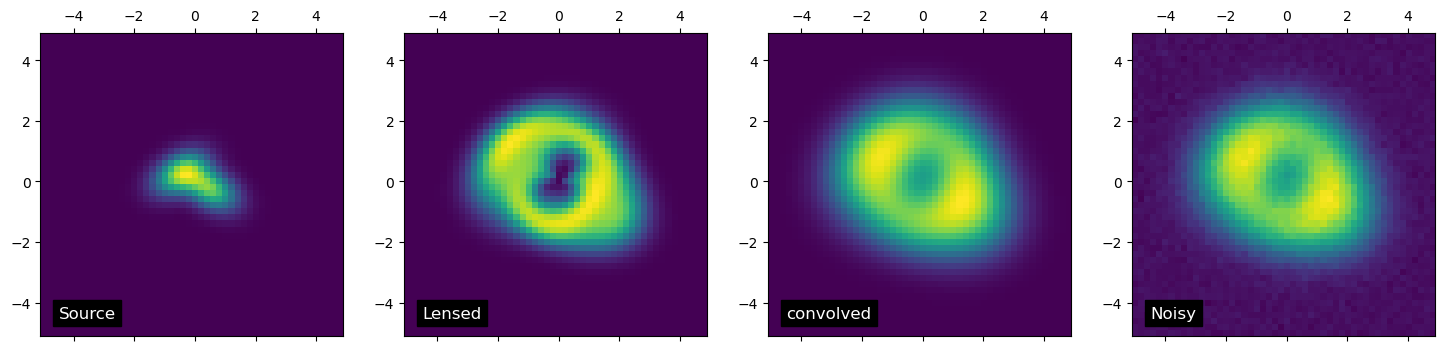

In [8]:
fig = plt.figure(figsize=(18,10))

r1 = fig.add_subplot(141)
cr1 = r1.matshow(sim_image_source,origin='lower', extent = image_grid_extent)
r1.text(-4.5, -4.5, 'Source', fontsize=12,c='w',backgroundcolor='black')

r2 = fig.add_subplot(142)
cr2 = r2.matshow(sim_image_lensed,origin='lower', extent = image_grid_extent)
r2.text(-4.5, -4.5, 'Lensed', fontsize=12,c='w',backgroundcolor='black')

r3 = fig.add_subplot(143)
cr3 = r3.matshow(sim_image_lensed_convolved,origin='lower', extent = image_grid_extent)
r3.text(-4.5, -4.5, 'convolved', fontsize=12,c='w',backgroundcolor='black')

r4 = fig.add_subplot(144)
cr4 = r4.matshow(sim_image_lensed_con_noisy,origin='lower', extent = image_grid_extent)
r4.text(-4.5, -4.5, 'Noisy', fontsize=12,c='w',backgroundcolor='black')

plt.show()

#### Pixelated Source Reconstruction
- Perform a pixelated reconstruction of the source image from the noisy simulated data.
- The reconstruction uses four lenstronomy classes:
    - `data_class`, `psf_class`, `lens_model_class`, and `source_pixel_grid_class`.

To ensure that the solving process is independent of the simulation, we define new class instances for reconstruction, even when some keyword arguments are the same.

In [9]:
# Define the data class for reconstruction.
# Unlike in simulation, we need to input the noisy data here.

kwargs_data_recon = kwargs_data_sim.copy()
kwargs_data_recon['image_data'] = sim_image_lensed_con_noisy # input the data image
data_class_recon = ImageData(**kwargs_data_recon)

In [10]:
# The PSF class is the same as in simulation,
# since we assume the same PSF is used for reconstruction.
psf_class_recon = PSF(**kwargs_psf_sim)

In [11]:
# Define the lens model class used in reconstruction
lens_model_list_recon = ['EPL']
kwargs_lens_recon = [{'theta_E':1.6, 'gamma':2, 'e1':0, 'e2':0.1, 'center_x':0.02, 'center_y':0.02}]
lens_model_class_recon = LensModel(lens_model_list=lens_model_list_recon)

In [12]:
# Define the source pixel grid class for reconstruction.
# This sets the region of the source plane where reconstruction is performed.
# Only square, unrotated source grids are currently supported.

source_pixel_width = 0.2 # pixel size of the source grid
source_pixel_num_x_axis = 30 # number of pixels in the x-direction
source_pixel_num_y_axis = 30 # number of pixels in the y-direction
ra_at_xy_0_source = -15 * 0.2 # the x coordinate of the [0,0] pixel, in arcsec
dec_at_xy_0_source = -15 * 0.2 # the y coordinate of the [0,0] pixel, in arcsec

transform_pix2angle = source_pixel_width * np.identity(2)
source_pixel_grid_class = PixelGrid(nx = source_pixel_num_x_axis, ny = source_pixel_num_y_axis, 
                                    transform_pix2angle = transform_pix2angle, 
                                    ra_at_xy_0 = ra_at_xy_0_source, dec_at_xy_0 = dec_at_xy_0_source)

Now import the pixelated source reconstruction module to perform the reconstruction:
- Generate the M matrix, b vector, and the regularization matrix U.
- Solve for the optimal regularization strength λ.
- Solve for the source pixel values using the linear equation $(M + \lambda U)a = b$.

In [13]:
# Define the PixelatedSourceReconstruction class
from lenstronomy.ImSim.SourceReconstruction.pixelated_source_reconstruction import PixelatedSourceReconstruction
PSR = PixelatedSourceReconstruction(data_class_recon, psf_class_recon, lens_model_class_recon, 
                                    source_pixel_grid_class)

In [14]:
# Compute the M matrix and b vector.
# This step may take a few seconds here,
# but will take longer for larger images or source grids.
M_pixel, b_pixel = PSR.generate_M_b(kwargs_lens_recon, verbose=True, show_progress=True)

number of source pixels: 900 (x axis: 30 pixels;  y axis: 30 pixels)
likelihood method: diagonal
Step 1: Lensing the source pixels
Step 1: Finished!
Step 2: Convolve the lensed pixels
Step 2: Finished!
Step 3: Compute the matrix M and vector b


Running (iteration times vary): 100%|██████████| 900/900 [00:06<00:00, 147.98it/s]

Step 3: Finished!


In [15]:
# Generate the regularization matrix
from lenstronomy.ImSim.SourceReconstruction.regularization_matrix_pixel import pixelated_regularization_matrix

# First two arguments are the number of pixels along x and y axes of the source grid.
# Supported regularization types: 'zeroth_order', 'gradient', 'curvature'
U_pixel = pixelated_regularization_matrix(source_pixel_num_x_axis, source_pixel_num_y_axis, 'curvature')

In [16]:
# Solve for the optimal regularization strength (lambda)

# The optimal lambda depends on many factors:
# lens model accuracy, source pixel size, noise level, etc.
# If the lens model is correct, lambda is typically around ~1/(background_rms²),
# varying within a few orders of magnitude.
# It is recommended to set the lower and upper bounds around that value.

from lenstronomy.ImSim.SourceReconstruction.solve_regularization_strength import d_log_evi_d_lambda
from lenstronomy.ImSim.SourceReconstruction.solve_regularization_strength import solve_optimal_lambda

In [17]:
# Explanation of inputs:

# d_log_evi_d_lambda: the derivative of log Evidence w.r.t. lambda.
#                     Lambda is optimized when this derivative crosses zero
#                     (from positive to negative).

# U_pixel, M_pixel, b_pixel: regularization matrix, M matrix, and b vector computed earlier.

# 1e2, 1e8: lower and upper bounds for lambda

# tolerance=1e-7, max_iterations=20: stopping criteria for iteration

# check_initial_bounds: if True, ensures the initial bounds give
#                       positive/negative signs for d log Evidence / d lambda.

optimal_lambda = solve_optimal_lambda(d_log_evi_d_lambda, U_pixel, M_pixel, b_pixel, 1e2, 1e6, 
                                      tolerance = 1e-7,
                                      max_iterations = 20,
                                      check_initial_bounds = True)
print('optimal_lambda:', optimal_lambda)

optimal_lambda: 808913.7447834015


In [18]:
# Solve for the pixel values of the source image
Lambda_U = optimal_lambda * U_pixel
source_grid_pixel_values = np.linalg.solve(M_pixel + Lambda_U, b_pixel)

In [19]:
# Generate result images:

# - The source image (only within the region defined by the source grid)
recon_source = source_grid_pixel_values.reshape(source_pixel_num_y_axis, source_pixel_num_x_axis)

# - Lensed pixelated source image
#   Use the PixelatedSourceReconstruction module again to lens this pixelated source
recon_lensed = PSR.lens_an_image_by_rayshooting(kwargs_lens_recon, recon_source)

# - Convolve the lensed model with the PSF
#   We use scipy.signal.fftconvolve for convolution outside of lenstronomy
recon_lensed_conv = scipy.signal.fftconvolve(recon_lensed, psf_class_recon.kernel_point_source, mode='same')

# - Residual image.
residual = sim_image_lensed_con_noisy - recon_lensed_conv

In [20]:
# Define the coordinates of the source grid for plotting
source_grid_extent = [source_pixel_grid_class.radec_at_xy_0[0] - 0.5 * source_pixel_grid_class.pixel_width,
                     source_pixel_grid_class.radec_at_xy_0[0] + 
                      (source_pixel_grid_class.num_pixel_axes[0]-0.5) * source_pixel_grid_class.pixel_width,
                     source_pixel_grid_class.radec_at_xy_0[1] - 0.5 * source_pixel_grid_class.pixel_width,
                     source_pixel_grid_class.radec_at_xy_0[1] + 
                      (source_pixel_grid_class.num_pixel_axes[1]-0.5) * source_pixel_grid_class.pixel_width]

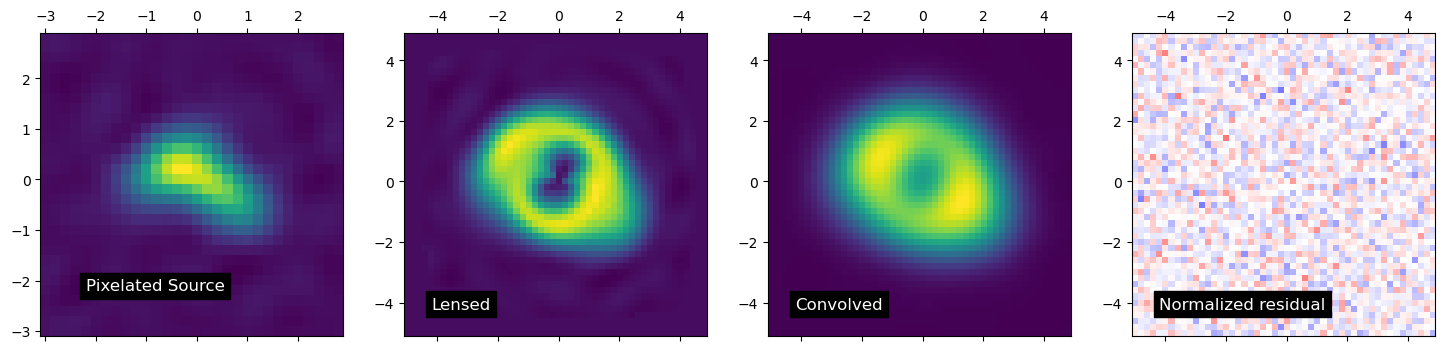

In [21]:
fig = plt.figure(figsize=(18,10))

r1 = fig.add_subplot(141)
cr1 = r1.matshow(recon_source, origin='lower', extent = source_grid_extent)
r1.text(-2.2, -2.2, 'Pixelated Source', fontsize=12,c='w',backgroundcolor='black')

r2 = fig.add_subplot(142)
cr2 = r2.matshow(recon_lensed,origin='lower', extent = image_grid_extent)
r2.text(-4.2, -4.2, 'Lensed', fontsize=12,c='w',backgroundcolor='black')

r3 = fig.add_subplot(143)
cr3 = r3.matshow(recon_lensed_conv, origin='lower', extent = image_grid_extent)
r3.text(-4.2, -4.2, 'Convolved', fontsize=12,c='w',backgroundcolor='black')

r4 = fig.add_subplot(144)
cr4 = r4.matshow(residual / background_rms, origin='lower', vmax=6, vmin=-6, cmap='bwr', extent = image_grid_extent)
r4.text(-4.2, -4.2, 'Normalized residual', fontsize=12,c='w',backgroundcolor='black')

plt.show()

In [22]:
# Compute the total magnification as the ratio of image flux to source flux
magnification = recon_lensed.sum() / recon_source.sum()
print("magnification:",magnification)

magnification: 5.816906896202566


#### Explore Variations in the Pipeline
Try adjusting key components in the reconstruction to gain deeper insight into the method:
##### Change the regularization strength (λ)
- How does the reconstructed source or residual change when:
     - `Lambda_U = optimal_lambda * U_pixel * 100` ?
     - `Lambda_U = optimal_lambda * U_pixel * 0.01` ?
- In general, a **larger Lambda_U** gives a **smoother** reconstructed source for the current regularization schemes we are using.
##### Change the source pixel grid
- Adjust the pixel size or choose a different region of the source plane.
    - (Note: the lower/upper bounds for `solve_optimal_lambda()` may need adjustment.)
- How does the reconstructed source look?
- Does the total flux magnification change?
##### Change the lens and source model parameters (in the simulation)
- Test how the method performs under different lensing configurations.
    - (Note: the lower/upper bounds for `solve_optimal_lambda()` may need adjustment.)

#### Warning:
If your **source grid does not fully cover** the actual flux region of the source, or if your **lens model or noise model is significantly incorrect**, the reconstruction may produce unphysical results.
It may **fail at the "Solve for the best regularization strength (lambda)"** step.